In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

# for reproducibility
torch.manual_seed(1)

In [2]:
image_size = 64

dataset = datasets.ImageFolder(root='../',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [3]:
batch_size = 10




dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [4]:
ngpu = 1
device = 'cuda'

In [5]:
print(device)
import numpy as np

cuda


RuntimeError: cuda runtime error (999) : unknown error at /pytorch/aten/src/THC/THCGeneral.cpp:47

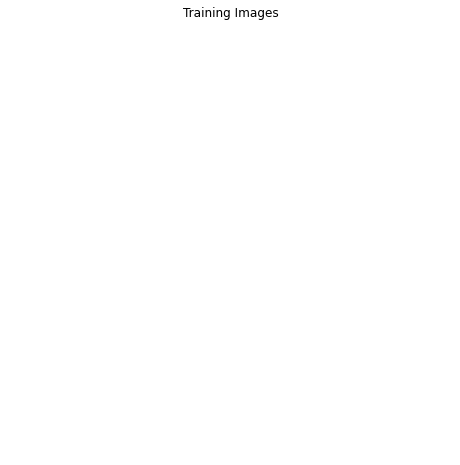

In [6]:
import torchvision.utils as vutils
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2),
        #### END CODE HERE ####
    )



def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        # Hint: Replace all of the "None" with the appropriate dimensions.
        # The documentation may be useful if you're less familiar with PyTorch:
        # https://pytorch.org/docs/stable/nn.html.
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
        #### END CODE HERE ####
    )

In [8]:
class Generator(nn.Module):
    def __init__(self, hidden_dim, noise_dim, img_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.BatchNorm1d(hidden_dim*4),
            nn.ReLU(inplace=True),
            
            nn.Linear(hidden_dim*4, img_dim),
            nn.Sigmoid()
            
        )
        
    def forward(self, noise):
         return gen(noise)
        
    

In [9]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            # There is a dropdown with hints if you need them! 
            #### START CODE HERE ####
            nn.Linear(hidden_dim*8, im_dim),
            nn.Sigmoid(),
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, img_dim, hidden_dim, slope):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
            nn.Linear(img_dim, hidden_dim*16),
            nn.BatchNorm1d(hidden_dim*16),
            nn.LeakyReLU(slope),
            
            nn.Linear(hidden_dim*16, hidden_dim*8),
            nn.BatchNorm1d(hidden_dim*8),
            nn.LeakyReLU(slope),
            
            nn.Linear(hidden_dim*8, hidden_dim*4),
            nn.BatchNorm1d(hidden_dim*4),
            nn.LeakyReLU(slope),
            
            nn.Linear(hidden_dim*4, 1),
        )
    def forward(self, image):
        return self.disc(image)

In [11]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1),
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)

In [12]:
def get_noise(n_samples, noise_dim, device='cpu'):
    noise = torch.randn(n_samples, noise_dim, device=device)
    return noise

In [13]:
noise_dim = (128, 100)

In [14]:


# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001



gen = Generator(hidden_dim = 128, noise_dim = z_dim, img_dim = 784).to(device=device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator(img_dim = image_size, hidden_dim = 128, slope = 0.2).to(device=device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
image_size

In [ ]:
## DEFINING DISCRIMINATOR AND GENERATOR LOSS

In [ ]:
def get_disc_loss(gen, disc, criterion, real_images, num_images, z_dim, device):
    '''
    gen = generator
    disc = discriminator
    criterion = loss function
    real_images = batch of real images
    num_images = number of image the generator is supposed to generate
    z_dim = noise dimension
    device = cuda or cpu
    '''
    noise_vecs = get_noise(num_images, z_dim, device = device)
    fake_images = gen(noise_vecs)
    
    real_pred = disc(real_images)
    fake_pred = disc(fake_images.detach())
    
    loss_real = criterion(real_pred, torch.ones_like(real_pred))
    loss_fake = criterion(fake_pred, torch.zeros_like(fake_pred))
    
    disc_loss = (loss_real + loss_fake) /2
    return disc_loss

In [ ]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    gen = generator
    disc = discriminator
    criterion = loss function
    real_images = batch of real images
    num_images = number of image the generator is supposed to generate
    z_dim = noise dimension
    device = cuda or cpu
    '''
    noise_vecs = get_noise(num_images, z_dim, device=device)
    fake_images = gen(noise_vecs)
    
    fake_pred = disc(fake_images)
    gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))
    
    return gen_loss
    
    
    

In [ ]:


import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''

    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


In [ ]:
import torchvision
batch_size = 64
dataloader = torch.utils.data.DataLoader( torchvision.datasets.MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)



In [ ]:
from tqdm import tqdm
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
n_epochs = 100

for epoch in range(n_epochs):
    
    
    for real,_ in tqdm(dataloader):
        
        curr_batch_size = len(real)
        
        # Flattening the batch 
        real = real.view(curr_batch_size, -1).to(device)
        
        ##### UPDATE DISCRIMINATOR ######
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, curr_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        #### UPDATE GENERATOR ######
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, curr_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        
        fake_noise = get_noise(curr_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        show_tensor_images(fake)
        
    

In [ ]:
def gen_block(input_dim, output_dim):
    '''This function will give a combined layer consisting of 
    1) Linear layer.
    2) Batch Regularization
    3) Relu'''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

In [ ]:
class Generator:
    '''This block defines the generator, which uses the gen_block function to declare layers'''
    def __init__(self, img_dim, hidden_dim, z_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            gen_block(z_dim, hidden_dim),
            gen_block(hidden_dim, hidden_dim*4),
            gen_block(hidden_dim*4, hidden_dim*8),
            gen_block(hidden_dim*8, hidden_dim*16),
            gen_block(hidden_dim*16, img_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return gen(noise)

In [ ]:
def disc_block(input_dim, output_dim, slope):
    '''This function will give a combined layer consisting of
    1) Linear layer
    2) Leaky Relu'''
    
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(slope),
    )

In [ ]:
class Discriminator:
    '''This block defines the discriminator, which uses the disc_block function to declare layers'''
    def __init__(self, img_dim, hidden_dim, z_dim):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            disc_block(img_dim, hidden_dim*16),
            disc_block()
        )